In [ ]:
!pip install pyswarms
!pip install pygad
!pip install deap
!pip install pymoo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import xgboost as xg
import tensorflow as tf
import math
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input, Activation, PReLU
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import random
from random import sample
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
import pygad
from deap import base, creator, tools, algorithms
from deap.benchmarks.tools import hypervolume
from collections import defaultdict
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.indicators.hv import HV
from sklearn.neural_network import MLPClassifier
import os
from sklearn.metrics import r2_score
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
import gc
from sklearn.neural_network import MLPRegressor
import joblib
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# EDA

In [ ]:
# Excel file path in Google Drive
file_path = '/content/drive/MyDrive/Data/DataMoreTargetNSGA.xlsx'
# Call the Excel file and save it in a variable
df = pd.read_excel(file_path)
# Definition of headers
columns = ['TC', 'TSF', 'S', 'FX', 'FY', 'DX', 'DY']
# Apply headers to the DataFrame
df = df.drop(df.columns[7:], axis=1)
df.columns = columns
df = df.sample(frac=1).reset_index(drop=True)
# Display the contents of the DataFrame with headers
print(df.head(5))
print(df.tail(5))
# Find the maximum and minimum of each column
column_max = df.max()
column_min = df.min()
print("column_max=")
print(column_max)
print("column_min=")
print(column_min)
# Normalize data in selected columns
df_normalized = (df - column_min) / (column_max - column_min)
# Sort by diameter and then number of steps
#df_normalized = df_normalized.sort_values()
# Display the new normalized DataFrame
print(df_normalized.head(5))
print(df_normalized.tail(5))

    TC  TSF   S      FX      FY        DX        DY
0  1.2  3.0  14  38.410 -7.1010  0.023355 -0.014039
1  1.0  2.0  14  14.300 -3.2284  0.025144 -0.015837
2  0.6  2.0  20   7.847 -1.4142  0.026561 -0.018163
3  1.0  3.0  10  31.672 -2.6005  0.023888 -0.015909
4  0.8  2.5  16  17.771 -3.9160  0.025552 -0.016657
      TC  TSF   S       FX      FY        DX        DY
187  1.2  3.0  16  37.2280 -8.3951  0.023121 -0.013776
188  1.6  2.5  12  39.8290 -7.6959  0.021902 -0.012877
189  0.8  1.5  20   4.9706 -1.0489  0.025778 -0.016572
190  0.8  2.5  18  16.6940 -3.1727  0.025508 -0.016687
191  0.8  1.5  14   6.5755 -1.6541  0.025389 -0.016249
column_max=
TC      1.600000
TSF     4.000000
S      20.000000
FX     85.930000
FY     -0.170630
DX      0.026950
DY     -0.009592
dtype: float64
column_min=
TC      0.600000
TSF     1.500000
S      10.000000
FX      3.476700
FY    -13.440000
DX      0.018292
DY     -0.018650
dtype: float64
    TC  TSF    S        FX        FY        DX        DY
0  0.6  0

In [ ]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TC      192 non-null    float64
 1   TSF     192 non-null    float64
 2   S       192 non-null    float64
 3   FX      192 non-null    float64
 4   FY      192 non-null    float64
 5   DX      192 non-null    float64
 6   DY      192 non-null    float64
dtypes: float64(7)
memory usage: 10.6 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TC,192.0,1.100000,0.342458,0.600000,0.800000,1.100000,1.400000,1.600000
TSF,192.0,2.640625,0.833535,1.500000,2.000000,2.500000,3.500000,4.000000
S,192.0,14.437500,3.199517,10.000000,12.000000,14.000000,16.500000,20.000000
FX,192.0,30.883564,21.297644,3.476700,14.135000,25.009500,45.295750,85.930000
FY,192.0,-4.680094,3.176988,-13.440000,-6.623900,-3.928500,-2.262875,-0.170630
DX,192.0,0.023535,0.001894,0.018292,0.022083,0.023749,0.025092,0.026950
DY,192.0,-0.014662,0.002085,-0.018650,-0.016436,-0.014819,-0.012977,-0.009592


In [ ]:
df_normalized.describe().T

,count,mean,std,min,25%,50%,75%,max
TC,192.0,0.500000,0.342458,0.0,0.200000,0.500000,0.800000,1.0
TSF,192.0,0.456250,0.333414,0.0,0.200000,0.400000,0.800000,1.0
S,192.0,0.443750,0.319952,0.0,0.200000,0.400000,0.650000,1.0
FX,192.0,0.332393,0.258299,0.0,0.129265,0.261151,0.507185,1.0
FY,192.0,0.660160,0.239423,0.0,0.513672,0.716801,0.842325,1.0
DX,192.0,0.605549,0.218805,0.0,0.437890,0.630342,0.785401,1.0
DY,192.0,0.440291,0.230130,0.0,0.244452,0.422941,0.626270,1.0


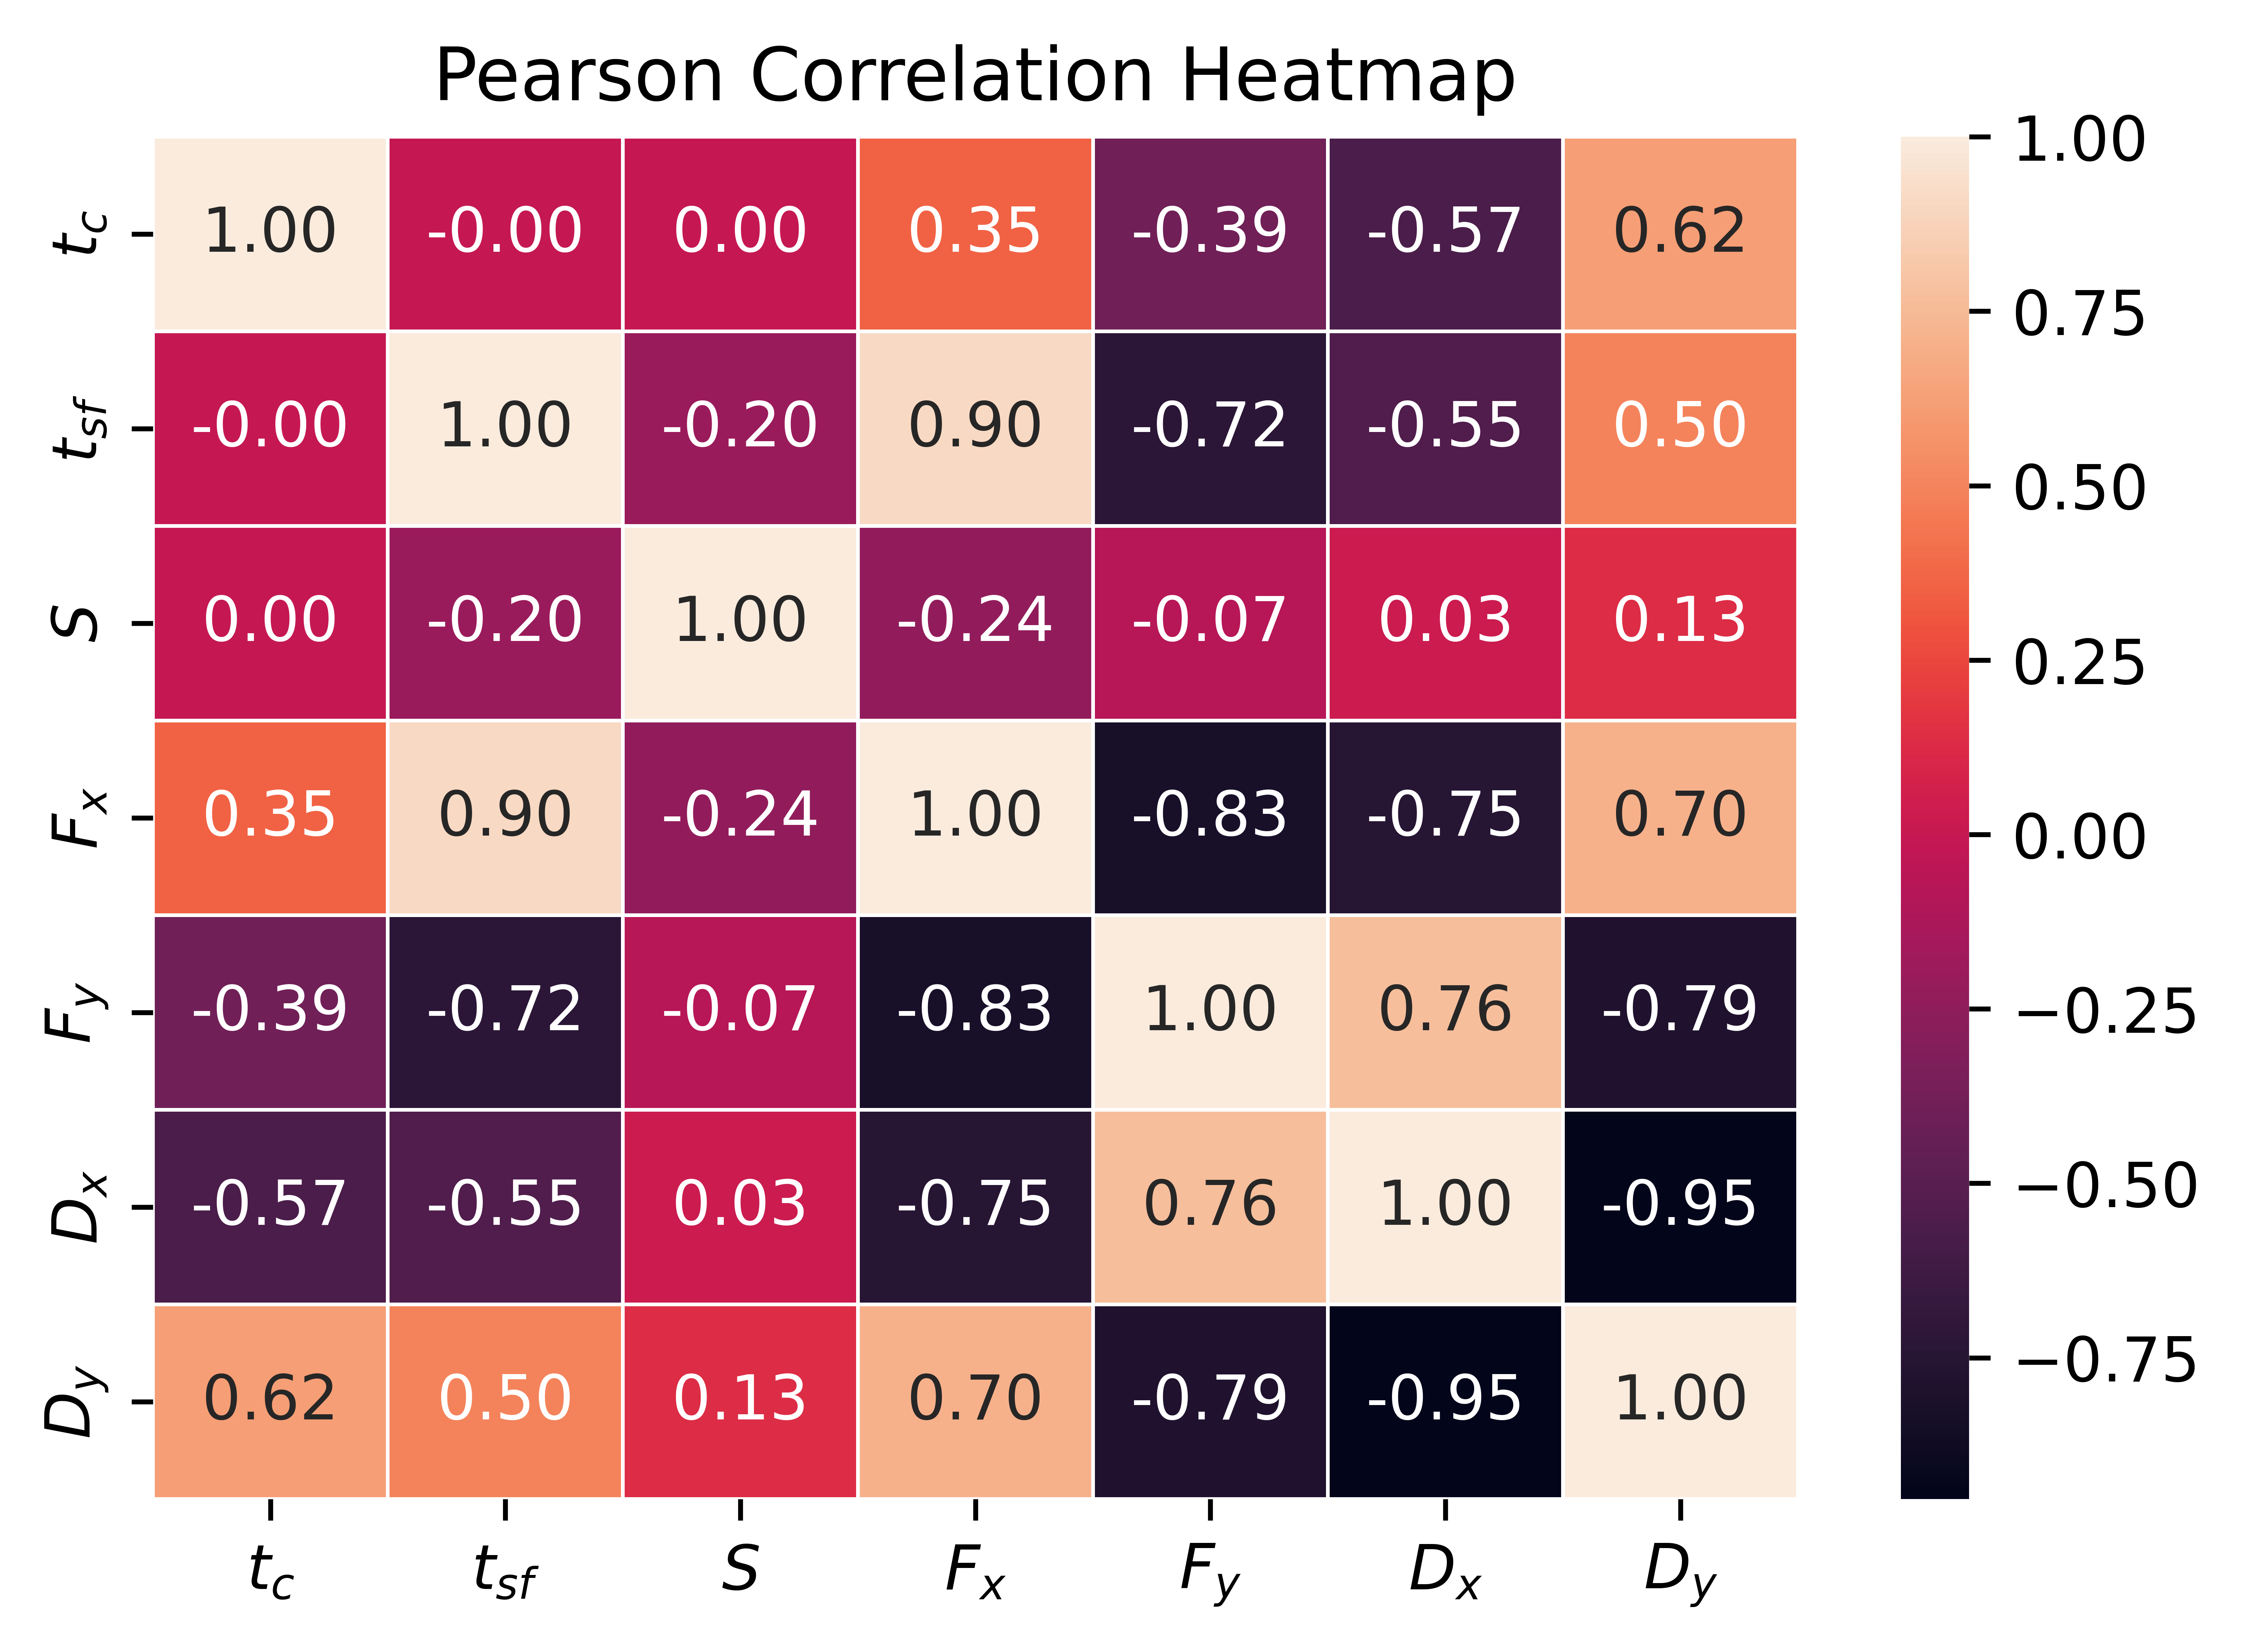

<Figure size 640x480 with 0 Axes>

In [ ]:
corr = abs(df_normalized).corr(method = 'pearson')
plt.figure(figsize=(6,4), dpi =1200)
x_axis_labels = ['$t_{c}$','$t_{sf}$','$S$','$F_{x}$','$F_{y}$','$D_{x}$','$D_{y}$']
y_axis_labels = ['$t_{c}$','$t_{sf}$','$S$','$F_{x}$','$F_{y}$','$D_{x}$','$D_{y}$']
sns.heatmap(corr,annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", linewidth=.5)
plt.title("Pearson Correlation Heatmap")
plt.savefig('Pearson.png', format='png', dpi=1200)
plt.show()
plt.draw()
files.download('Pearson.png')

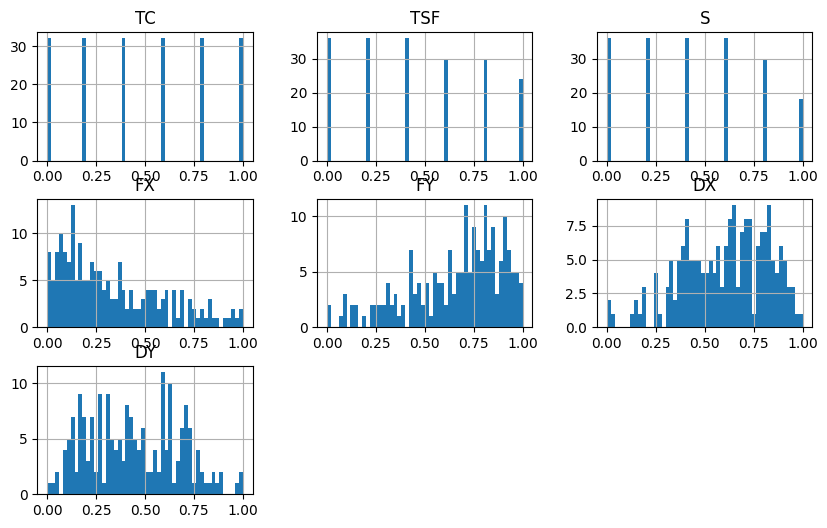

In [ ]:
hist = df_normalized.hist(bins=50, figsize=(10, 6))

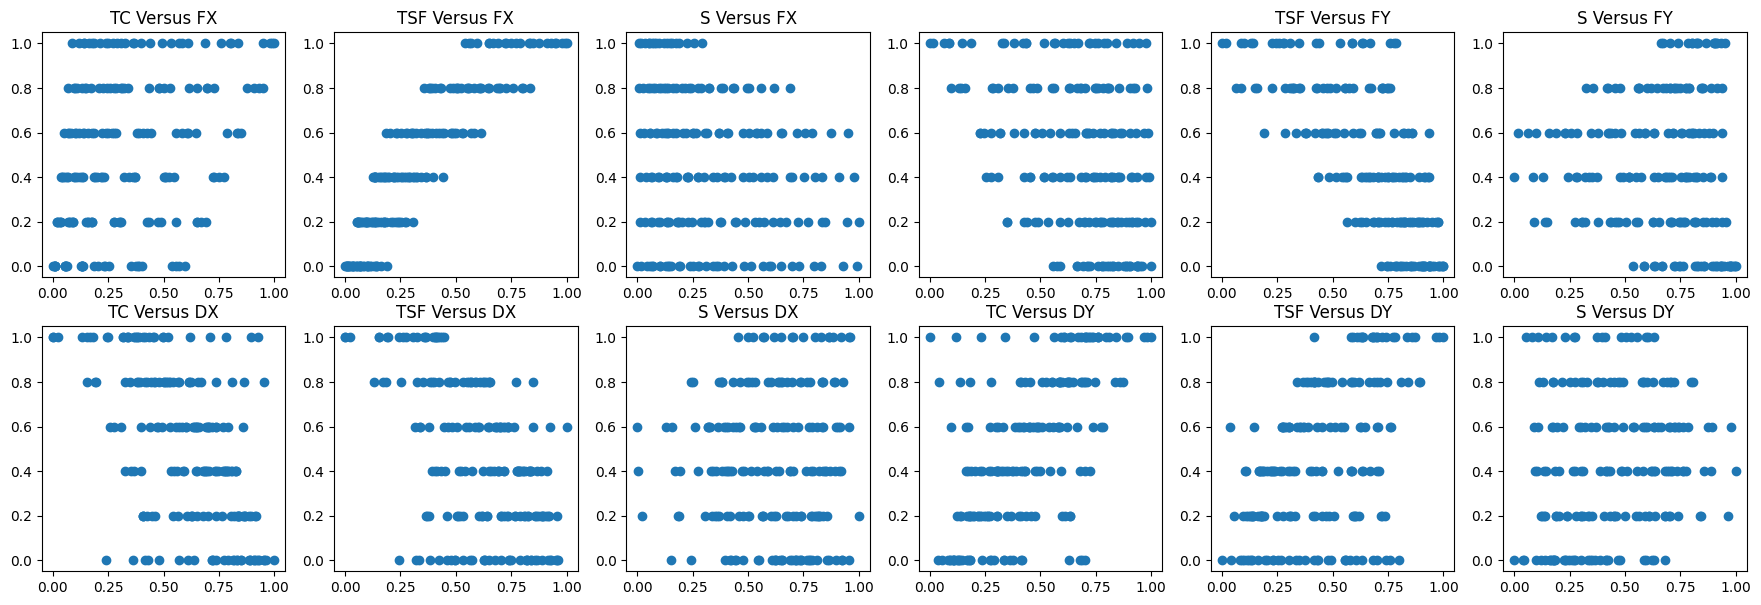

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 7))
ax[0][0].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TC"])
ax[0][0].title.set_text('TC Versus FX')
ax[0][1].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TSF"])
ax[0][1].title.set_text('TSF Versus FX')
ax[0][2].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"S"])
ax[0][2].title.set_text('S Versus FX')
ax[0][3].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TC"])
ax[0][4].title.set_text('TC Versus FY')
ax[0][4].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TSF"])
ax[0][4].title.set_text('TSF Versus FY')
ax[0][5].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"S"])
ax[0][5].title.set_text('S Versus FY')
ax[1][0].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TC"])
ax[1][0].title.set_text('TC Versus DX')
ax[1][1].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TSF"])
ax[1][1].title.set_text('TSF Versus DX')
ax[1][2].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"S"])
ax[1][2].title.set_text('S Versus DX')
ax[1][3].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TC"])
ax[1][3].title.set_text('TC Versus DY')
ax[1][4].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TSF"])
ax[1][4].title.set_text('TSF Versus DY')
ax[1][5].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"S"])
ax[1][5].title.set_text('S Versus DY')
plt.show()

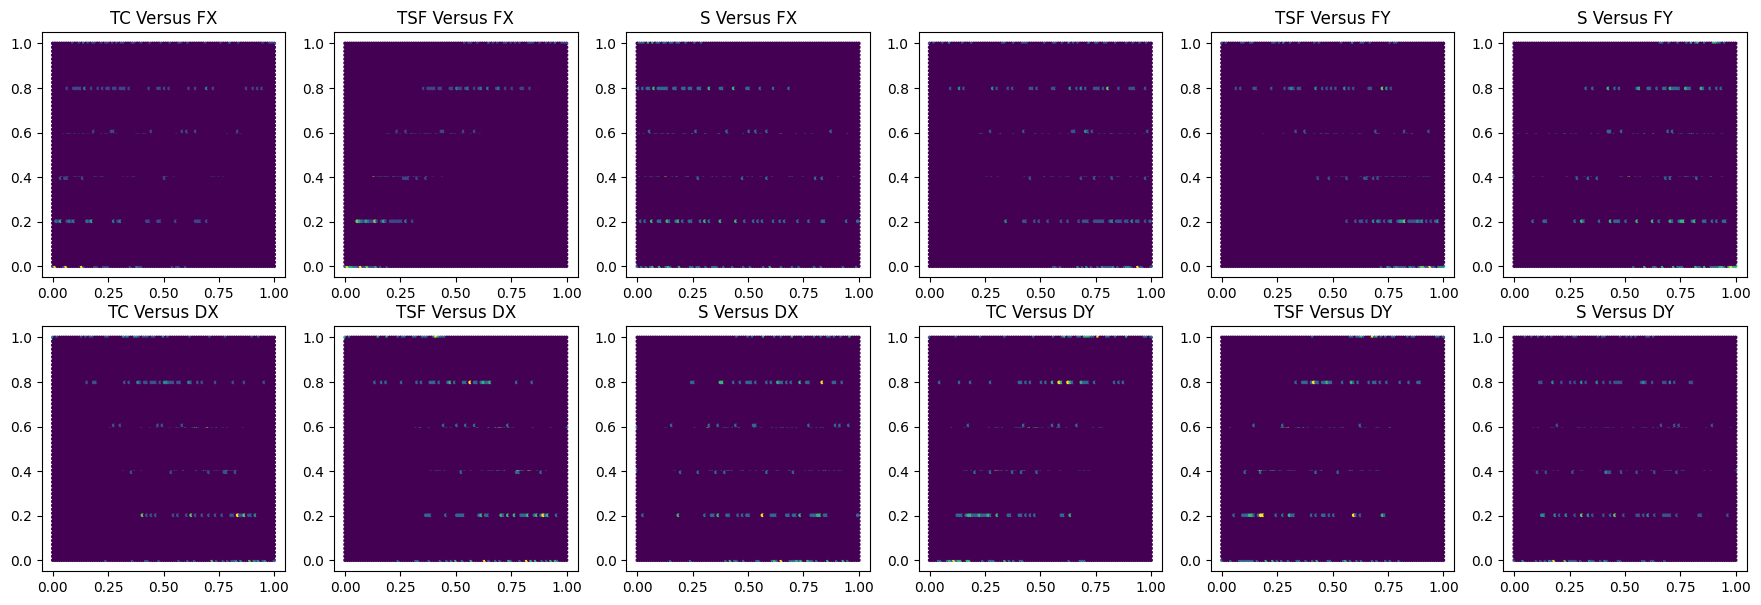

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 7))
ax[0][0].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TC"])
ax[0][0].title.set_text('TC Versus FX')
ax[0][1].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TSF"])
ax[0][1].title.set_text('TSF Versus FX')
ax[0][2].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"S"])
ax[0][2].title.set_text('S Versus FX')
ax[0][3].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TC"])
ax[0][4].title.set_text('TC Versus FY')
ax[0][4].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TSF"])
ax[0][4].title.set_text('TSF Versus FY')
ax[0][5].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"S"])
ax[0][5].title.set_text('S Versus FY')
ax[1][0].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TC"])
ax[1][0].title.set_text('TC Versus DX')
ax[1][1].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TSF"])
ax[1][1].title.set_text('TSF Versus DX')
ax[1][2].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"S"])
ax[1][2].title.set_text('S Versus DX')
ax[1][3].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TC"])
ax[1][3].title.set_text('TC Versus DY')
ax[1][4].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TSF"])
ax[1][4].title.set_text('TSF Versus DY')
ax[1][5].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"S"])
ax[1][5].title.set_text('S Versus DY')
plt.show()

In [ ]:
input_data_train_val, x_test_data, target_train_val, y_test_data = train_test_split(df_normalized.iloc[:, 0:3], df_normalized.iloc[:, 3:7], test_size=0.1, random_state=123)
input_data, x_val_data, target, y_val_data = train_test_split(input_data_train_val, target_train_val, test_size=1/9, random_state=123)
input_data = np.array(input_data)
x_test_data = np.array(x_test_data)
target = np.array(target)
y_test_data = np.array(y_test_data)
x_val_data = np.array(x_val_data)
y_val_data = np.array(y_val_data)
input_data_train_val = np.array(input_data_train_val)
target_train_val = np.array(target_train_val)

# MLP Search

In [ ]:
# Define a function to build the model
def create_model(num_neurons_l1, num_neurons_l2, num_neurons_l3, activation, dropout_rate, regularizers_l2_rate):
    input = Input(shape=(3,))
    hidden_layer_1 = Dense(num_neurons_l1, activation=activation, kernel_regularizer=regularizers.l2(regularizers_l2_rate))(input)
    dropout_1 = Dropout(dropout_rate)(hidden_layer_1)
    hidden_layer_2 = Dense(num_neurons_l2, activation=activation, kernel_regularizer=regularizers.l2(regularizers_l2_rate))(dropout_1)
    dropout_2 = Dropout(dropout_rate)(hidden_layer_2)
    hidden_layer_3 = Dense(num_neurons_l3, activation=activation, kernel_regularizer=regularizers.l2(regularizers_l2_rate))(dropout_2)
    dropout_3 = Dropout(dropout_rate)(hidden_layer_3)
    output_layer = Dense(4, activation='sigmoid', kernel_regularizer=regularizers.l2(regularizers_l2_rate))(dropout_3)
    model = Model(inputs=input, outputs=output_layer)
    return model

#Define network parameters
num_neurons_1 = [3, 4, 5, 6, 7, 8, 9, 10] #[256,128,32]
num_neurons_2 = [3, 4, 5, 6, 7, 8, 9, 10] #[256,128,32]
num_neurons_3 = [3, 4, 5, 6, 7, 8, 9, 10] #[256,128,32]
activations = ['tanh']
dropout_rate_list = [0]
regularizers_l2_rate_list = [0]
# DataFrame to store the results
results = []
best_score = float('inf')
best_params = None

# Searching a network with nested loops
for num_neurons1 in num_neurons_1:
  for num_neurons2 in num_neurons_2:
    for num_neurons3 in num_neurons_3:
      for dropout_rate in dropout_rate_list:
        for activation in activations:
          for regularizers_l2_rate in regularizers_l2_rate_list:
            model = create_model(num_neurons1, num_neurons2, num_neurons3, activation, dropout_rate, regularizers_l2_rate)
            model.compile(optimizer='adam', loss='mean_squared_error')

            #Model training
            model.fit(input_data, target, epochs=50, batch_size=1, verbose=0)

            # Prediction and evaluation
            y_pred = model.predict(x_val_data)
            score = mean_squared_error(y_val_data, y_pred)
            # Store the results in a DataFrame
            results.append({
                    'Neurons1': num_neurons1,
                    'Neurons2': num_neurons2,
                    'Neurons3': num_neurons3,
                    'Activation': activation,
                    'Dropout': dropout_rate,
                    'regularizers_l2_rate': regularizers_l2_rate,
                    'Score': score
                })
            del model
            gc.collect()

In [ ]:
#Create a DataFrame from the results
results_df = pd.DataFrame(results)

#Sort DataFrame based on error value (Score)
results_df = results_df.sort_values(by='Score')

#Selection of three networks with the lowest amount of error
top_10_results = results_df.head(10)

#Display the best parameters and result
print("Top 10 models:")
print(top_10_results)

# MLP

In [ ]:
input = Input(shape=(3,))
hidden_layer_1 = Dense(9, activation="tanh")(input)
dropout_1 = Dropout(0)(hidden_layer_1)
hidden_layer_2 = Dense(10, activation="tanh")(dropout_1)
dropout_2 = Dropout(0)(hidden_layer_2)
hidden_layer_3 = Dense(7, activation="tanh")(dropout_2)
dropout_3 = Dropout(0)(hidden_layer_3)
output_layer = Dense(4, activation="sigmoid")(dropout_3)

# Regressor model
regressor = Model(input, output_layer)
regressor.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 9)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 7)                   │              77 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 4)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245 (980.00 B)

 Trainable params: 245 (980.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
# Fit the model with adam optimizer and binary cross entropy
regressor.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

train_loss_per_epoch = []
val_loss_per_epoch = []

for train_index, val_index in kf.split(input_data_train_val):
    # validation and train split
    X_train, X_val = input_data_train_val[train_index], input_data_train_val[val_index]
    y_train, y_val = target_train_val[train_index], target_train_val[val_index]

    # model train
    history = regressor.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val))

    train_loss_per_epoch.append(history.history['loss'])
    val_loss_per_epoch.append(history.history['val_loss'])

mean_train_loss_per_epoch = [sum(epoch_losses) / k for epoch_losses in zip(*train_loss_per_epoch)]
mean_val_loss_per_epoch = [sum(epoch_losses) / k for epoch_losses in zip(*val_loss_per_epoch)]

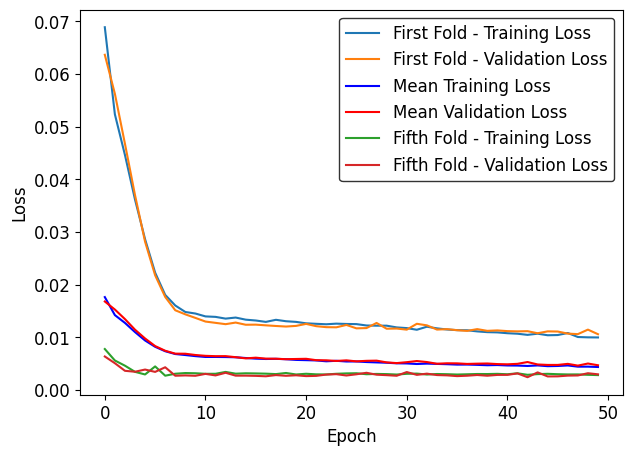

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.figure(figsize=(7, 5))

plt.plot(train_loss_per_epoch[0], linestyle='-', label='First Fold - Training Loss')
plt.plot(val_loss_per_epoch[0], linestyle='-', label='First Fold - Validation Loss')
plt.plot(mean_train_loss_per_epoch, linestyle='-', color='b', label='Mean Training Loss')
plt.plot(mean_val_loss_per_epoch, linestyle='-', color='r', label='Mean Validation Loss')
plt.plot(train_loss_per_epoch[4], linestyle='-', label='Fifth Fold - Training Loss')
plt.plot(val_loss_per_epoch[4], linestyle='-', label='Fifth Fold - Validation Loss')

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(edgecolor='black', prop={'size': 12})
plt.xlabel('Epoch', fontsize='12')
plt.ylabel('Loss', fontsize='12')
plt.savefig('MeanMLPLoss.png', format='png', dpi=1200)
plt.show()
plt.draw()
files.download('MeanMLPLoss.png')

In [ ]:
#predict testdata with model
predictions = regressor.predict(input_data)
predictions.shape

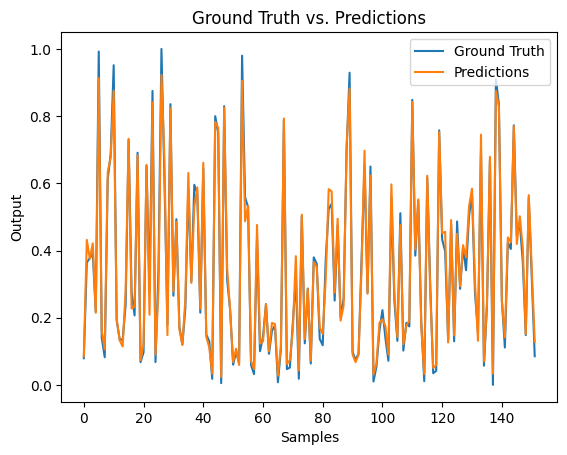

In [ ]:
x = range(len(input_data))
plt.plot(x, target[:,0], label='Ground Truth')
plt.plot(x, predictions[:,0], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

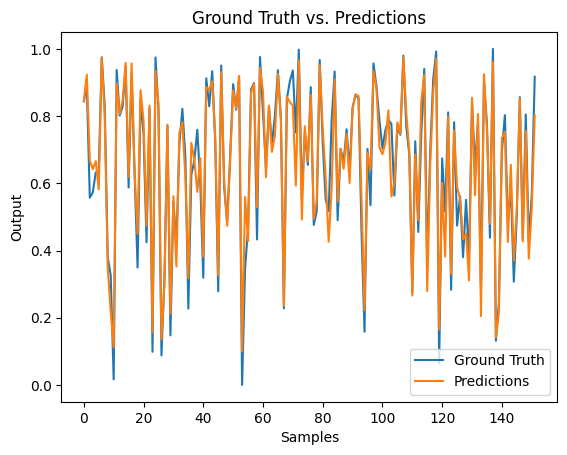

In [ ]:
plt.plot(x, target[:,1], label='Ground Truth')
plt.plot(x, predictions[:,1], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

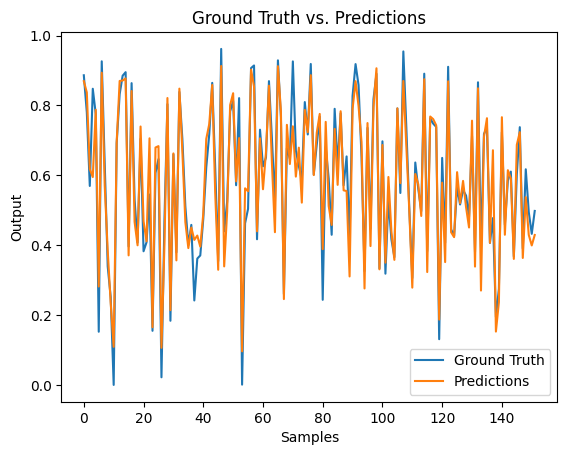

In [ ]:
x = range(len(input_data))
plt.plot(x, target[:,2], label='Ground Truth')
plt.plot(x, predictions[:,2], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

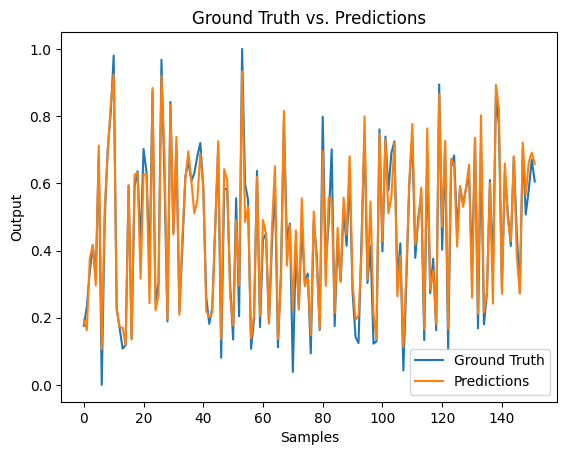

In [ ]:
x = range(len(input_data))
plt.plot(x, target[:,3], label='Ground Truth')
plt.plot(x, predictions[:,3], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error FX (MAE):", metrics.mean_absolute_error(target[:,0], predictions[:,0]))
print("Mean Squared Error FX (MSE):", metrics.mean_squared_error(target[:,0], predictions[:,0]))
print("R2_score FX:", metrics.r2_score(target[:,0], predictions[:,0]))
print("Mean Absolute Error FY (MAE):", metrics.mean_absolute_error(target[:,1], predictions[:,1]))
print("Mean Squared Error FY (MSE):", metrics.mean_squared_error(target[:,1], predictions[:,1]))
print("R2_score FY:", metrics.r2_score(target[:,1], predictions[:,1]))
print("Mean Absolute Error DX (MAE):", metrics.mean_absolute_error(target[:,2], predictions[:,2]))
print("Mean Squared Error DX (MSE):", metrics.mean_squared_error(target[:,2], predictions[:,2]))
print("R2_score DX:", metrics.r2_score(target[:,2], predictions[:,2]))
print("Mean Absolute Error DY (MAE):", metrics.mean_absolute_error(target[:,3], predictions[:,3]))
print("Mean Squared Error DY (MSE):", metrics.mean_squared_error(target[:,3], predictions[:,3]))
print("R2_score DY:", metrics.r2_score(target[:,3], predictions[:,3]))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(target, predictions))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(target, predictions))
print("R2_score:", metrics.r2_score(target, predictions))

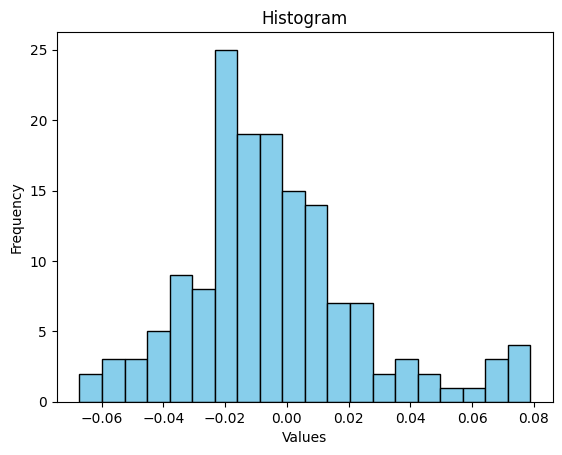

In [ ]:
Error_train_0 = target[:,0] - predictions[:,0]
plt.hist(Error_train_0, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

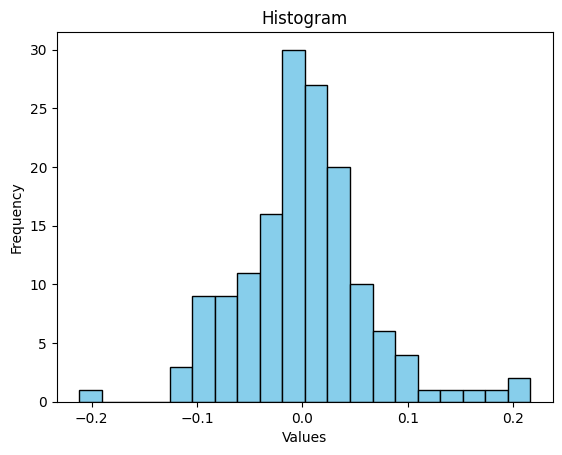

In [ ]:
Error_train_1 = target[:,1] - predictions[:,1]
plt.hist(Error_train_1, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

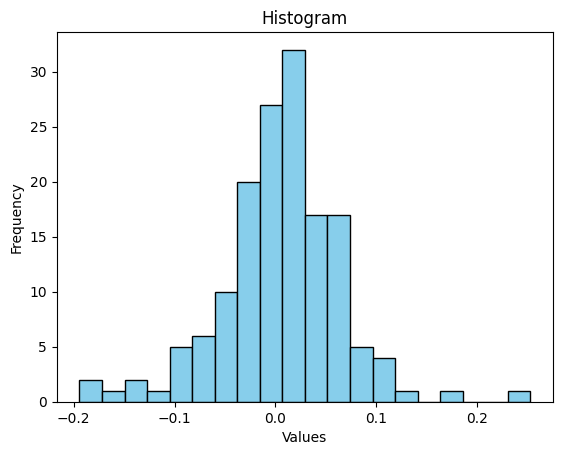

In [ ]:
Error_train_2 = target[:,2] - predictions[:,2]
plt.hist(Error_train_2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

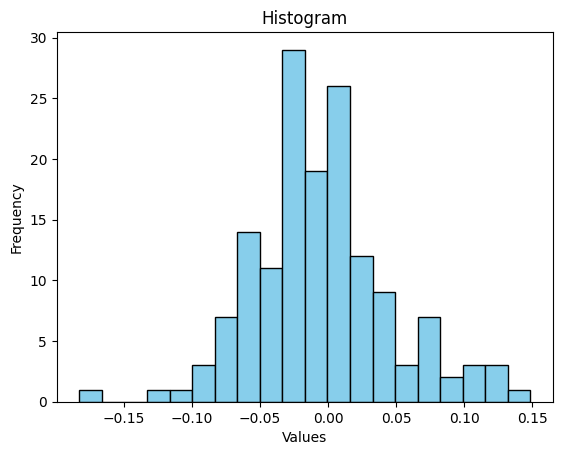

In [ ]:
Error_train_3 = target[:,3] - predictions[:,3]
plt.hist(Error_train_3, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [ ]:
#predict testdata with model
predictions = regressor.predict(x_val_data)
predictions.shape

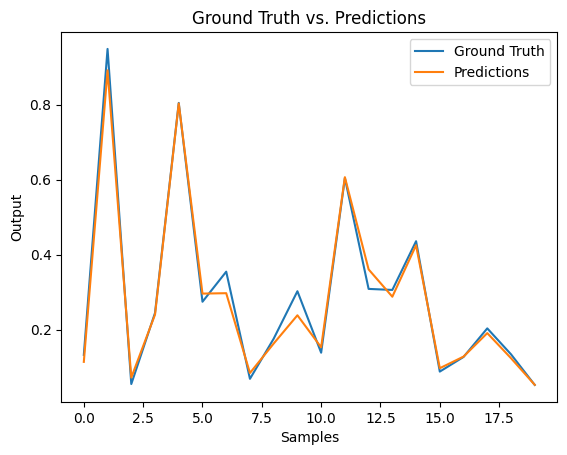

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,0], label='Ground Truth')
plt.plot(x, predictions[:,0], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

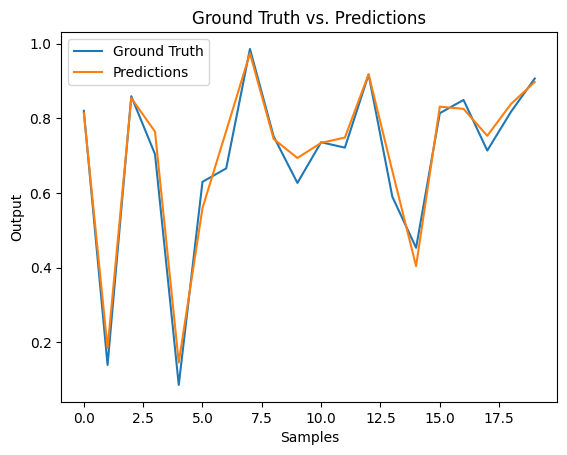

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,1], label='Ground Truth')
plt.plot(x, predictions[:,1], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

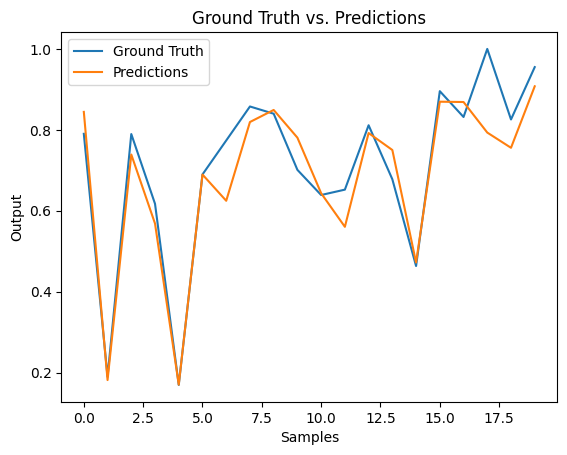

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,2], label='Ground Truth')
plt.plot(x, predictions[:,2], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

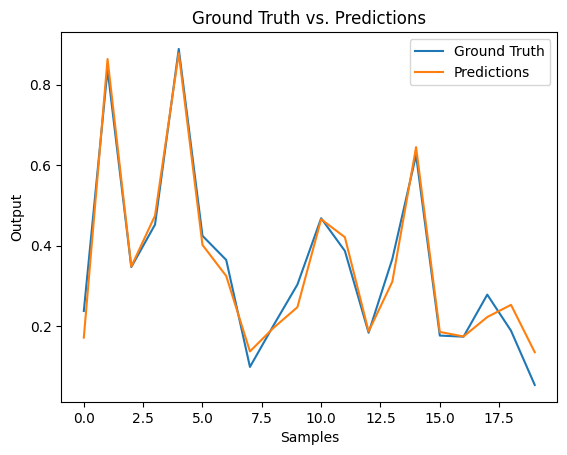

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,3], label='Ground Truth')
plt.plot(x, predictions[:,3], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error FX (MAE):", metrics.mean_absolute_error(y_val_data[:,0], predictions[:,0]))
print("Mean Squared Error FX (MSE):", metrics.mean_squared_error(y_val_data[:,0], predictions[:,0]))
print("R2_score FX:", metrics.r2_score(y_val_data[:,0], predictions[:,0]))
print("Mean Absolute Error FY (MAE):", metrics.mean_absolute_error(y_val_data[:,1], predictions[:,1]))
print("Mean Squared Error FY (MSE):", metrics.mean_squared_error(y_val_data[:,1], predictions[:,1]))
print("R2_score FY:", metrics.r2_score(y_val_data[:,1], predictions[:,1]))
print("Mean Absolute Error DX (MAE):", metrics.mean_absolute_error(y_val_data[:,2], predictions[:,2]))
print("Mean Squared Error DX (MSE):", metrics.mean_squared_error(y_val_data[:,2], predictions[:,2]))
print("R2_score DX:", metrics.r2_score(y_val_data[:,2], predictions[:,2]))
print("Mean Absolute Error DY (MAE):", metrics.mean_absolute_error(y_val_data[:,3], predictions[:,3]))
print("Mean Squared Error DY (MSE):", metrics.mean_squared_error(y_val_data[:,3], predictions[:,3]))
print("R2_score DY:", metrics.r2_score(y_val_data[:,3], predictions[:,3]))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_val_data, predictions))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_val_data, predictions))
print("R2_score:", metrics.r2_score(y_val_data, predictions))

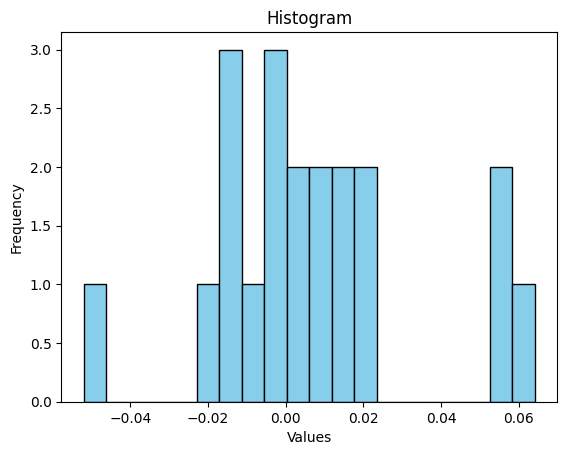

In [ ]:
Error_val_0 = y_val_data[:,0] - predictions[:,0]
plt.hist(Error_val_0, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

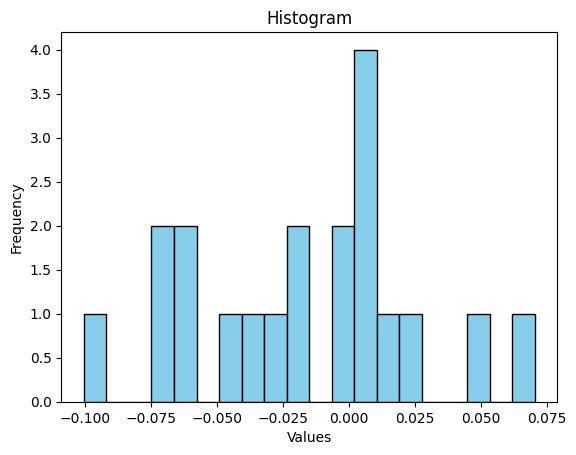

In [ ]:
Error_val_1 = y_val_data[:,1] - predictions[:,1]
plt.hist(Error_val_1, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

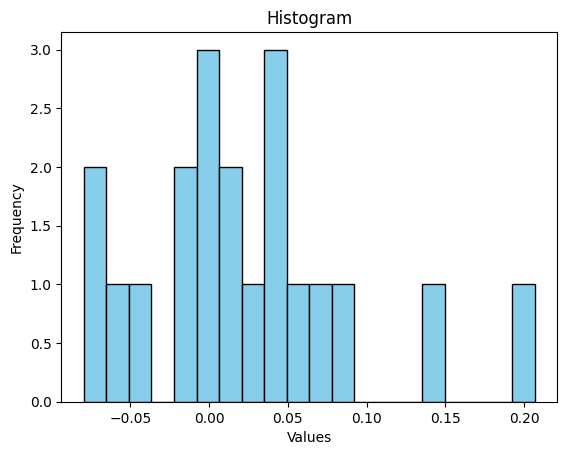

In [ ]:
Error_val_2 = y_val_data[:,2] - predictions[:,2]
plt.hist(Error_val_2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

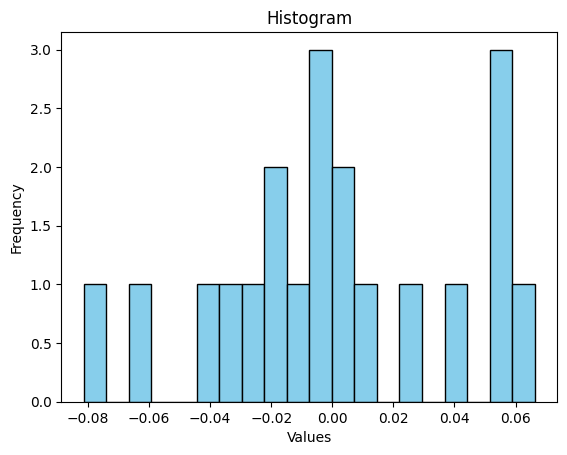

In [ ]:
Error_val_3 = y_val_data[:,3] - predictions[:,3]
plt.hist(Error_val_3, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [ ]:
#predict testdata with model
predictions = regressor.predict(x_test_data)
predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


(20, 4)

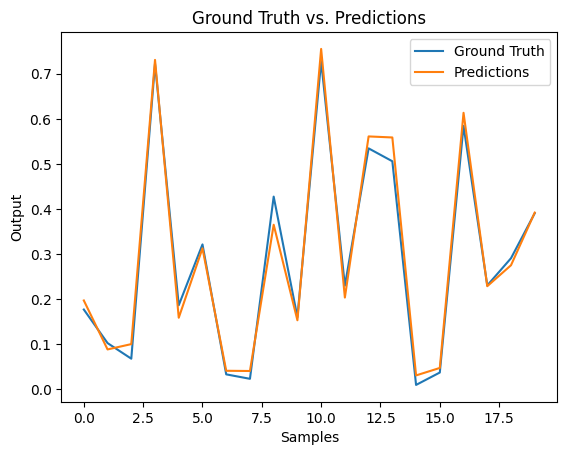

In [ ]:
x = range(len(x_test_data))
plt.plot(x, y_test_data[:,0], label='Ground Truth')
plt.plot(x, predictions[:,0], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

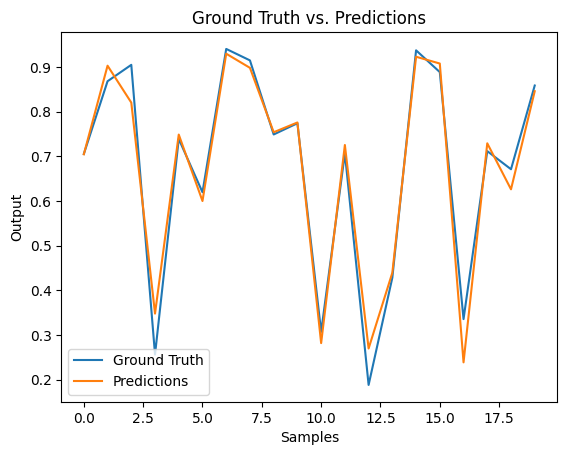

In [ ]:
plt.plot(x, y_test_data[:,1], label='Ground Truth')
plt.plot(x, predictions[:,1], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

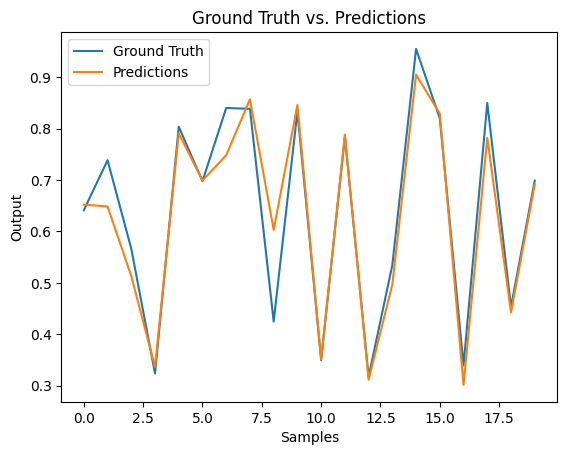

In [ ]:
plt.plot(x, y_test_data[:,2], label='Ground Truth')
plt.plot(x, predictions[:,2], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

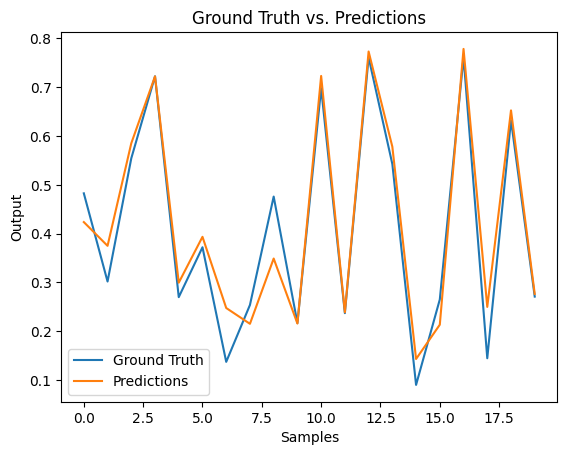

In [ ]:
plt.plot(x, y_test_data[:,3], label='Ground Truth')
plt.plot(x, predictions[:,3], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error FX (MAE):", metrics.mean_absolute_error(y_test_data[:,0], predictions[:,0]))
print("Mean Squared Error FX (MSE):", metrics.mean_squared_error(y_test_data[:,0], predictions[:,0]))
print("R2_score FX:", metrics.r2_score(y_test_data[:,0], predictions[:,0]))
print("Mean Absolute Error FY (MAE):", metrics.mean_absolute_error(y_test_data[:,1], predictions[:,1]))
print("Mean Squared Error FY (MSE):", metrics.mean_squared_error(y_test_data[:,1], predictions[:,1]))
print("R2_score FY:", metrics.r2_score(y_test_data[:,1], predictions[:,1]))
print("Mean Absolute Error DX (MAE):", metrics.mean_absolute_error(y_test_data[:,2], predictions[:,2]))
print("Mean Squared Error DX (MSE):", metrics.mean_squared_error(y_test_data[:,2], predictions[:,2]))
print("R2_score DX:", metrics.r2_score(y_test_data[:,2], predictions[:,2]))
print("Mean Absolute Error DY (MAE):", metrics.mean_absolute_error(y_test_data[:,3], predictions[:,3]))
print("Mean Squared Error DY (MSE):", metrics.mean_squared_error(y_test_data[:,3], predictions[:,3]))
print("R2_score DY:", metrics.r2_score(y_test_data[:,3], predictions[:,3]))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test_data, predictions))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test_data, predictions))
print("R2_score:", metrics.r2_score(y_test_data, predictions))

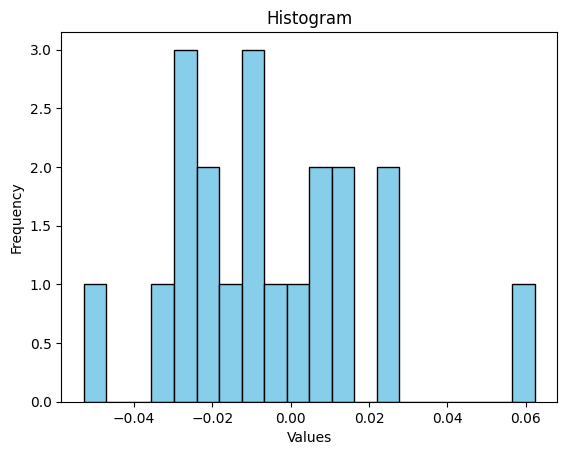

In [ ]:
Error_test_0 = y_test_data[:,0] - predictions[:,0]
plt.hist(Error_test_0, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

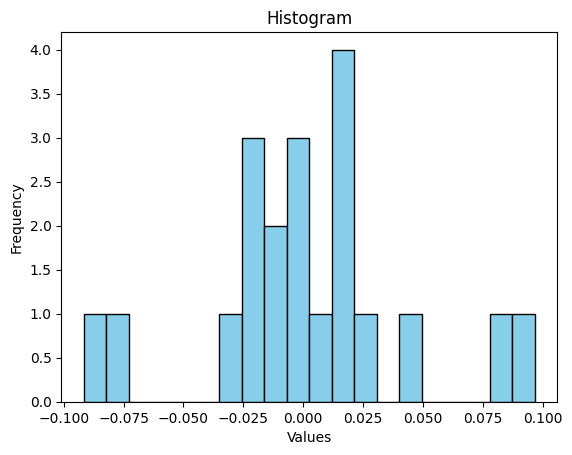

In [ ]:
Error_test_1 = y_test_data[:,1] - predictions[:,1]
plt.hist(Error_test_1, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

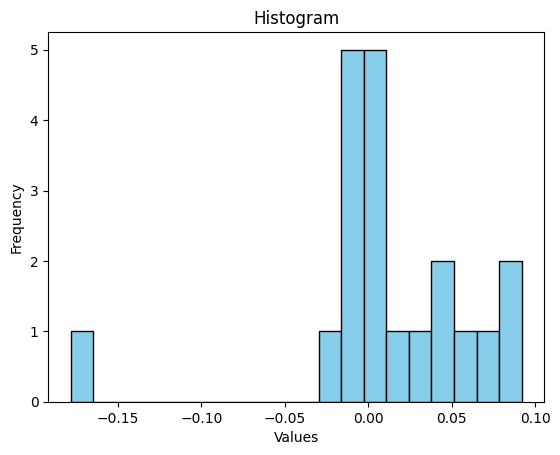

In [ ]:
Error_test_2 = y_test_data[:,2] - predictions[:,2]
plt.hist(Error_test_2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

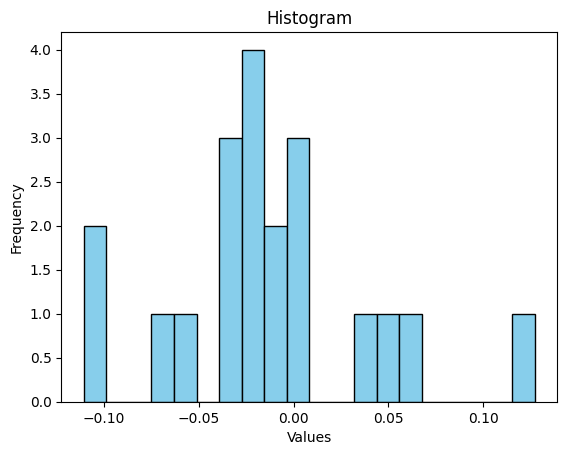

In [ ]:
Error_test_3 = y_test_data[:,3] - predictions[:,3]
plt.hist(Error_test_3, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [ ]:
pred_all = regressor.predict(df_normalized.iloc[:, 0:3])
pred_all = pd.DataFrame(pred_all)
pred_all.columns = ['FX', 'FY', 'DX', 'DY']
denormalized_all = df
min_pred = df.iloc[:, 3:7].min()
max_pred = df.iloc[:, 3:7].max()
denormalized_pred_all = ((pred_all.iloc[:, 0:4])*(max_pred - min_pred)) + min_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


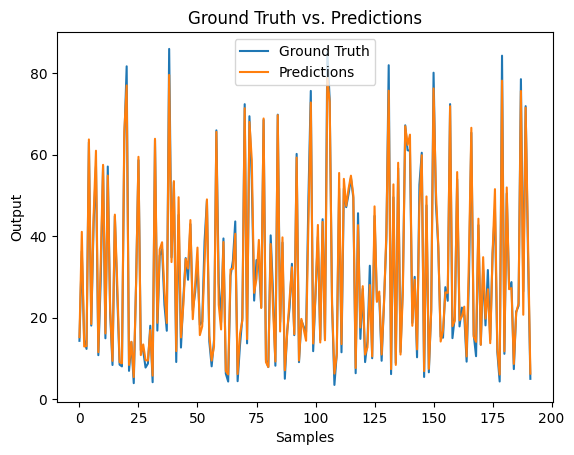

In [ ]:
x = range(len(denormalized_all))
plt.plot(x, df.iloc[:, 3:4], label='Ground Truth')
plt.plot(x, denormalized_pred_all.iloc[:, 0:1], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

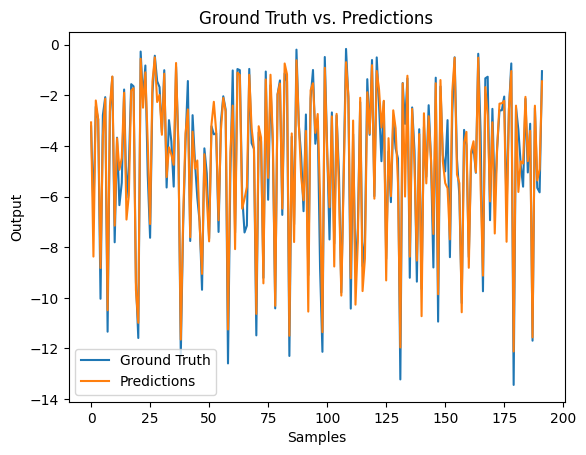

In [ ]:
plt.plot(x, df.iloc[:, 4:5], label='Ground Truth')
plt.plot(x, denormalized_pred_all.iloc[:, 1:2], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

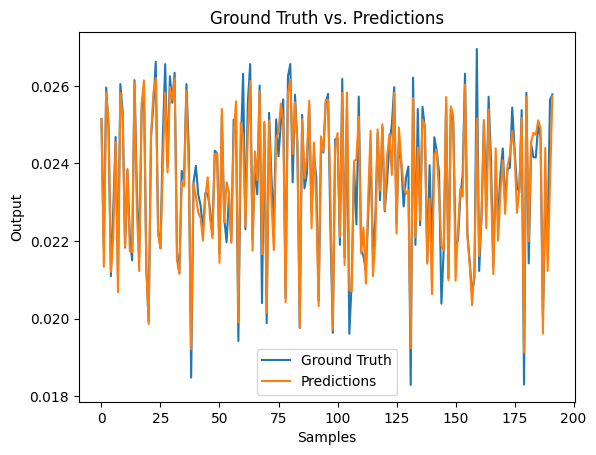

In [ ]:
plt.plot(x, df.iloc[:, 5:6], label='Ground Truth')
plt.plot(x, denormalized_pred_all.iloc[:, 2:3], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

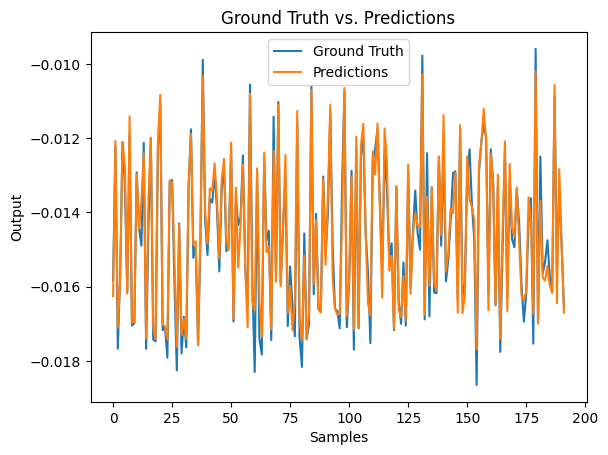

In [ ]:
plt.plot(x, df.iloc[:, 6:7], label='Ground Truth')
plt.plot(x, denormalized_pred_all.iloc[:, 3:4], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

In [ ]:
print("Mean Absolute Error FX (MAE):", metrics.mean_absolute_error(df.iloc[:, 3:4], denormalized_pred_all.iloc[:, 0:1]))
print("Mean Squared Error FX (MSE):", metrics.mean_squared_error(df.iloc[:, 3:4], denormalized_pred_all.iloc[:, 0:1]))
print("R2_score FX:", metrics.r2_score(df.iloc[:, 3:4], denormalized_pred_all.iloc[:, 0:1]))
print("Mean Absolute Error FY (MAE):", metrics.mean_absolute_error(df.iloc[:, 4:5], denormalized_pred_all.iloc[:, 1:2]))
print("Mean Squared Error FY (MSE):", metrics.mean_squared_error(df.iloc[:, 4:5], denormalized_pred_all.iloc[:, 1:2]))
print("R2_score FY:", metrics.r2_score(df.iloc[:, 4:5], denormalized_pred_all.iloc[:, 1:2]))
print("Mean Absolute Error DX (MAE):", metrics.mean_absolute_error(df.iloc[:, 5:6], denormalized_pred_all.iloc[:, 2:3]))
print("Mean Squared Error DX (MSE):", metrics.mean_squared_error(df.iloc[:, 5:6], denormalized_pred_all.iloc[:, 2:3]))
print("R2_score DX:", metrics.r2_score(df.iloc[:, 5:6], denormalized_pred_all.iloc[:, 2:3]))
print("Mean Absolute Error DY (MAE):", metrics.mean_absolute_error(df.iloc[:, 6:7], denormalized_pred_all.iloc[:, 3:4]))
print("Mean Squared Error DY (MSE):", metrics.mean_squared_error(df.iloc[:, 6:7], denormalized_pred_all.iloc[:, 3:4]))
print("R2_score DY:", metrics.r2_score(df.iloc[:, 6:7], denormalized_pred_all.iloc[:, 3:4]))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(df.iloc[:, 3:7], denormalized_pred_all))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(df.iloc[:, 3:7], denormalized_pred_all))
print("R2_score:", metrics.r2_score(df.iloc[:, 3:7], denormalized_pred_all))

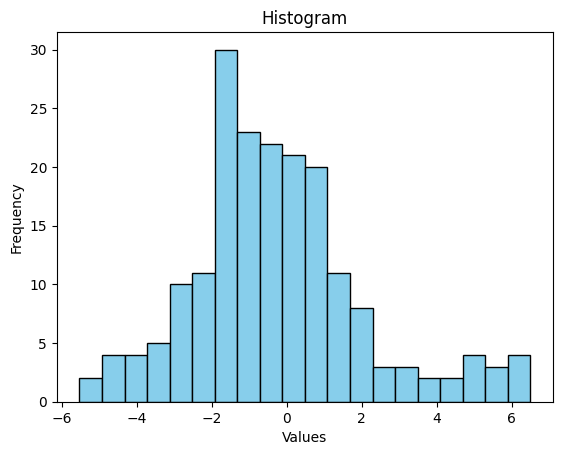

In [ ]:
Error_all_0 = df.iloc[:, 3:4] - denormalized_pred_all.iloc[:, 0:1]
plt.hist(Error_all_0, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

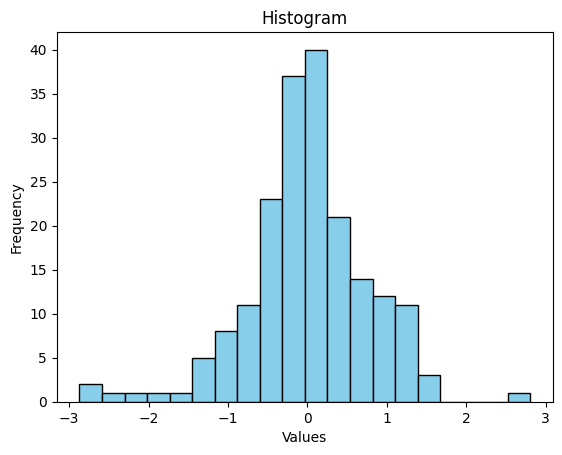

In [ ]:
Error_all_1 = denormalized_pred_all.iloc[:, 1:2] - df.iloc[:, 4:5]
plt.hist(Error_all_1, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

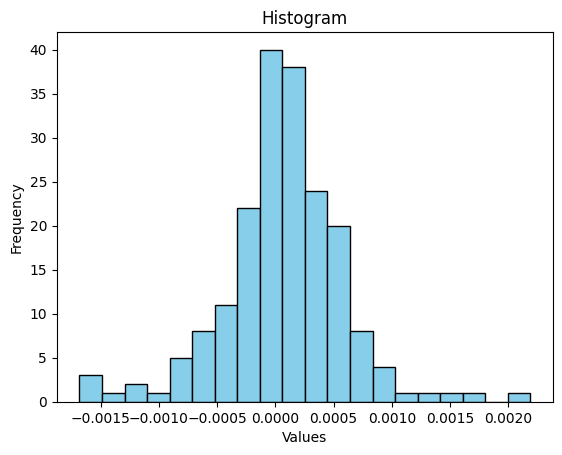

In [ ]:
Error_all_2 = df.iloc[:, 5:6] - denormalized_pred_all.iloc[:, 2:3]
plt.hist(Error_all_2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

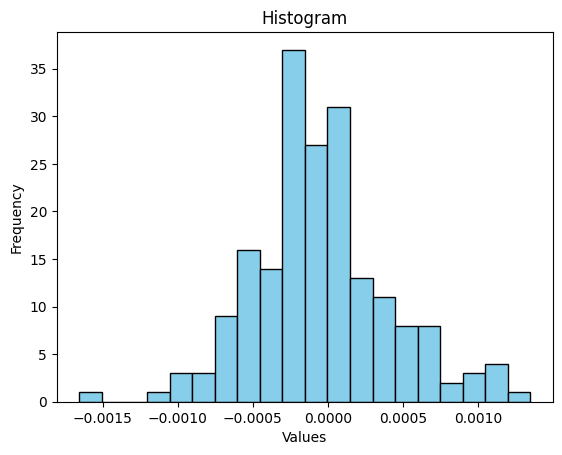

In [ ]:
Error_all_3 = df.iloc[:, 6:7] - denormalized_pred_all.iloc[:, 3:4]
plt.hist(Error_all_3, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

# Save Model

In [ ]:
regressor.save('/content/drive/MyDrive/SavedModels/MLP_modelfinal.h5')

# Load Model

In [ ]:
model = load_model('/content/drive/MyDrive/SavedModels/MLP_modelfinal.h5')

In [ ]:
#predict test with model
predictions = model.predict(x_val_data)
predictions.shape

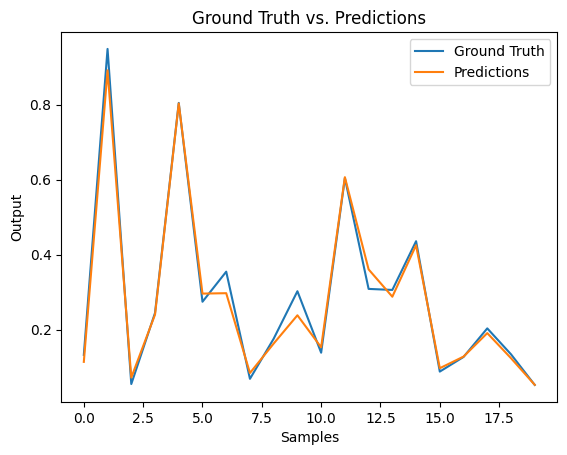

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,0], label='Ground Truth')
plt.plot(x, predictions[:,0], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()